# Import the required libraries

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Get the CSV file

In [2]:
all_packets_path = "main-experiment-1/ap_all_packets.csv"

all_packets = pd.read_csv(all_packets_path)

The CSV file is obtained by selecting the required fields from the PCAP using Wireshark.  
The fields are:
- Time
- Source
- Destination
- Protocol
- Sequence number
- Antenna signal
- MCS index
- Length
- Retry
- A-MPDU reference number

In [3]:
filter_condition = all_packets["Protocol"] == "UDP"
udp_packets = all_packets[filter_condition == True]

We select only the data frames. These frames have the UDP protocol field.

In [4]:
# Check the total number of UDP frames in consideration
print(len(udp_packets))

159963


In [5]:
print(udp_packets.head())

    No.      Time       Source  Destination Protocol  Sequence number  \
15   16  0.407359  192.168.1.1  192.168.1.2      UDP              0.0   
16   17  0.407359  192.168.1.1  192.168.1.2      UDP              1.0   
17   18  0.407359  192.168.1.1  192.168.1.2      UDP              2.0   
18   19  0.407359  192.168.1.1  192.168.1.2      UDP              3.0   
19   20  0.407359  192.168.1.1  192.168.1.2      UDP              4.0   

   Antenna signal  MCS index  Length                             Retry  \
15            NaN        6.0  1420.0  Frame is not being retransmitted   
16            NaN        6.0  1420.0  Frame is not being retransmitted   
17            NaN        6.0  1420.0  Frame is not being retransmitted   
18            NaN        6.0  1420.0  Frame is not being retransmitted   
19            NaN        6.0  1420.0  Frame is not being retransmitted   

    A-MPDU reference number  MAC timestamp  
15                      0.0         508868  
16                      0.

In [6]:
time = udp_packets["Time"]
sequence_numbers = udp_packets["Sequence number"]
retries = udp_packets["Retry"]
mcs_values = udp_packets["MCS index"]
data = udp_packets["Length"]
ampdu_ref = udp_packets["A-MPDU reference number"]

We create copies of the columns that we are interested in  
- Time
- Sequence number
- Retry
- MCS index
- Length of Data
- A-MPDU reference number

In [7]:
print(sequence_numbers.isna().sum())

0


Check if any data frame is missing a sequence number

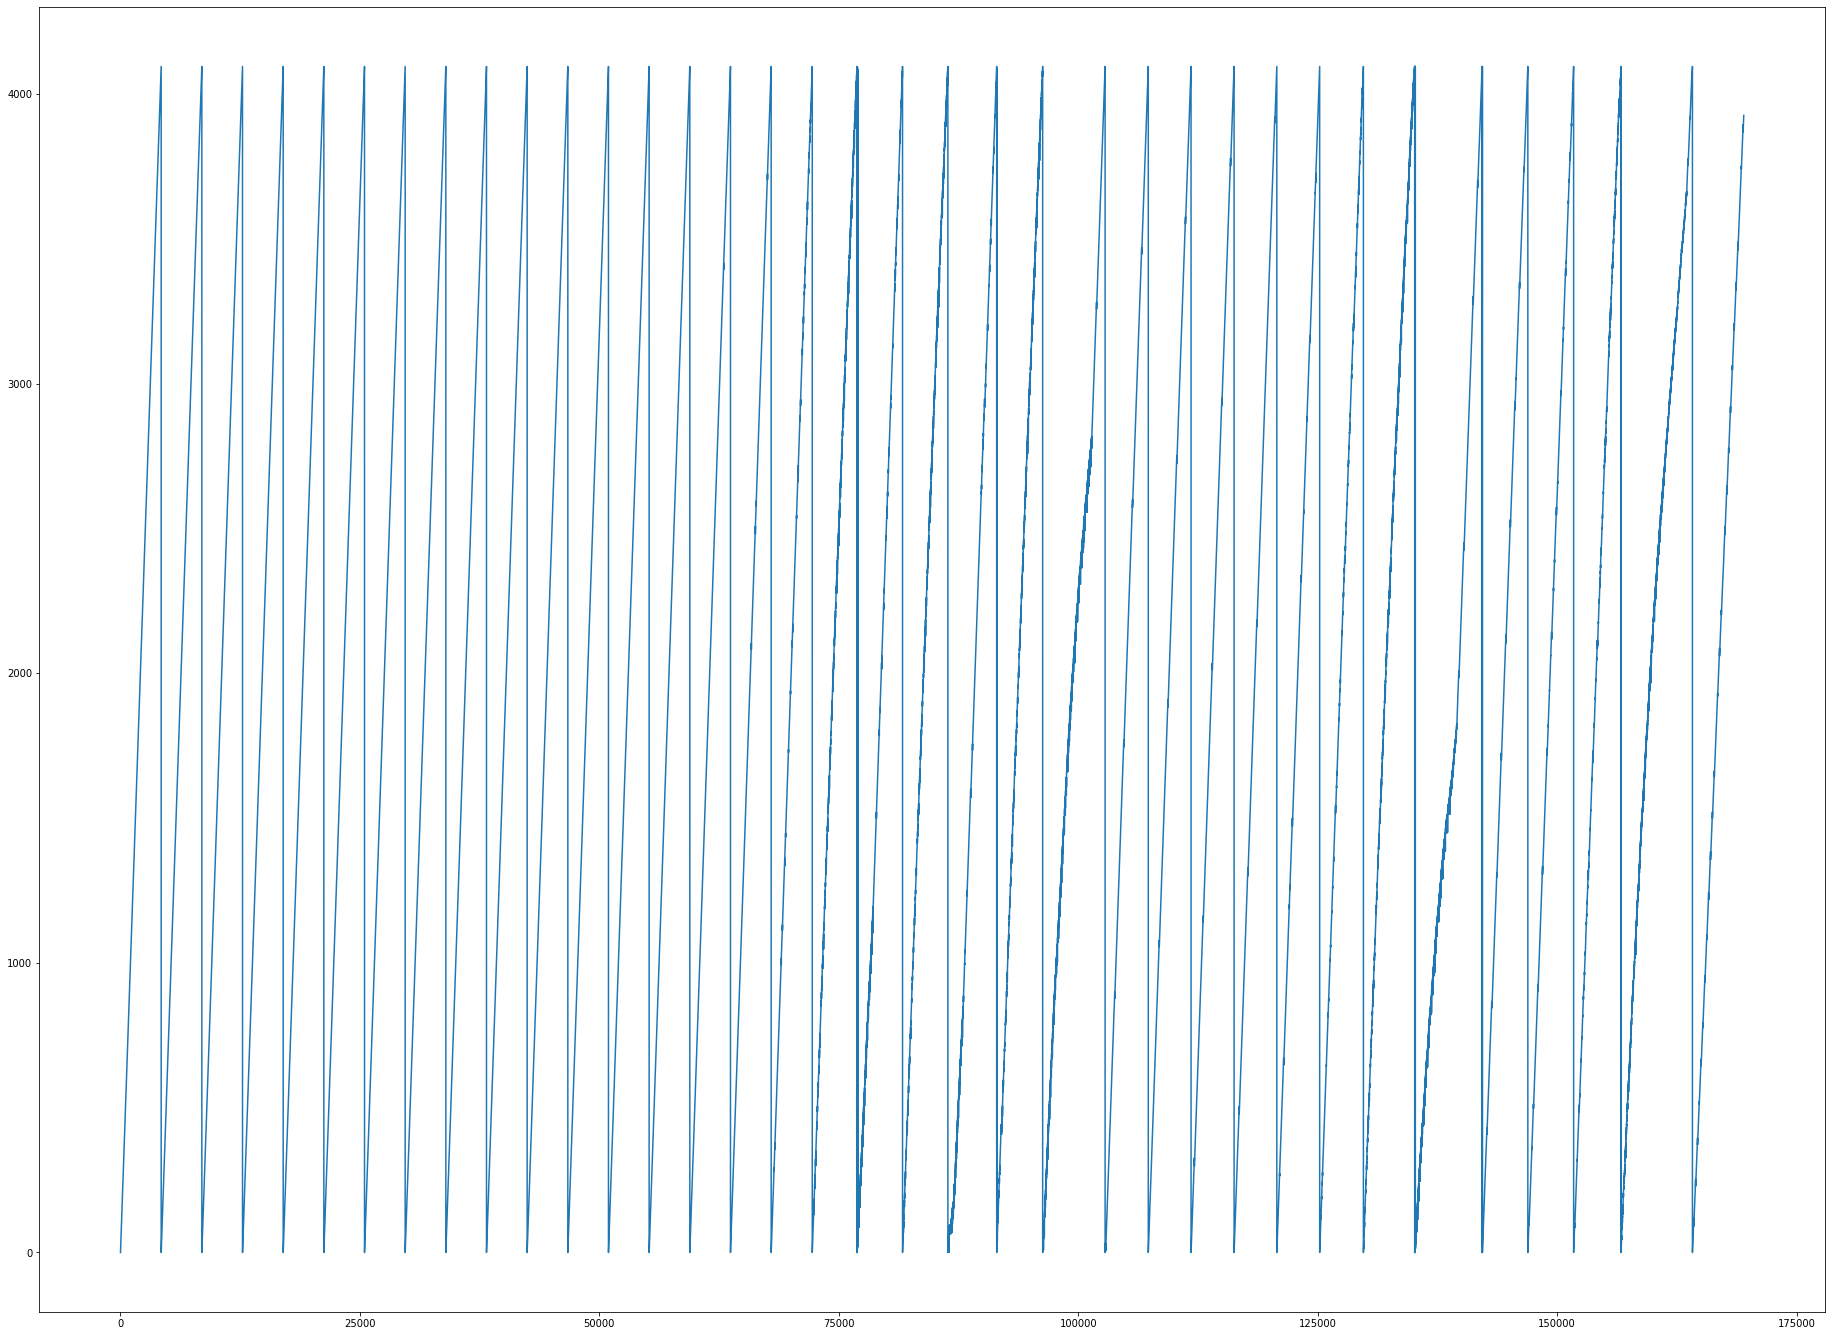

In [8]:
plt.figure(figsize=(32, 24))
plt.plot(sequence_numbers)
plt.show()

Plot the sequence numbers to notice the pattern and if there are any inconsistencies

# Unroll the sequence numbers to get a unique sequence number for each data frame

In [9]:
def unroll(seq_nums):
    max_seq_num = 4096
    transition_region = max_seq_num/4
    transition_threshold = max_seq_num/2
    counter = 0
    counter_hyst = 0
    new_seq_num = []
    
    for _, seq_num in seq_nums.items():
        if seq_num >= 0 and seq_num <= transition_threshold and counter_hyst != 0:
            new_seq_num.append(seq_num + counter*max_seq_num)
        elif seq_num > transition_threshold and counter_hyst != 0:
            new_seq_num.append(seq_num + (counter-1)*max_seq_num)
        else:
            new_seq_num.append(seq_num + counter*max_seq_num)
            
        if seq_num == max_seq_num-1 and counter_hyst == 0:
            counter += 1
            counter_hyst = 1
        elif counter_hyst > 0:
            counter_hyst += 1
            
        if counter_hyst >= transition_region:
            counter_hyst = 0
            
    udp_packets["New Sequence number"] = new_seq_num

We consider that the sequence numbers can spill into not later than 25% of the next cycle. And that the value of these spilled over sequence numbers can only be in the second half of the previous cycle.

In [10]:
unroll(sequence_numbers)

/home/rishi/Programs/NS3_analysis/nsvenv/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
new_sequence_numbers = udp_packets["New Sequence number"]

We add a new column called "New Sequence number" which consists of the "unrolled" sequence numbers for each packet

In [12]:
plt.figure(figsize=(32, 24))
plt.plot(new_sequence_numbers)
plt.show()

We plot the new sequence numbers to check for any inconsistencies

In [13]:
print(udp_packets.head())

    No.      Time       Source  Destination Protocol  Sequence number  \
15   16  0.407359  192.168.1.1  192.168.1.2      UDP              0.0   
16   17  0.407359  192.168.1.1  192.168.1.2      UDP              1.0   
17   18  0.407359  192.168.1.1  192.168.1.2      UDP              2.0   
18   19  0.407359  192.168.1.1  192.168.1.2      UDP              3.0   
19   20  0.407359  192.168.1.1  192.168.1.2      UDP              4.0   

   Antenna signal  MCS index  Length                             Retry  \
15            NaN        6.0  1420.0  Frame is not being retransmitted   
16            NaN        6.0  1420.0  Frame is not being retransmitted   
17            NaN        6.0  1420.0  Frame is not being retransmitted   
18            NaN        6.0  1420.0  Frame is not being retransmitted   
19            NaN        6.0  1420.0  Frame is not being retransmitted   

    A-MPDU reference number  MAC timestamp  New Sequence number  
15                      0.0         508868        

# Plotting the number of retries per sequence number

In [14]:
num_retries = np.zeros(len(udp_packets))

In [15]:
for i in range(0, len(udp_packets)):
    unique_sequence_number = int(new_sequence_numbers.iloc[i])
    if retries.iloc[i] == "Frame is being retransmitted":
        num_retries[unique_sequence_number] += 1

In [16]:
print(num_retries.min())
print(num_retries.max())

0.0
16.0


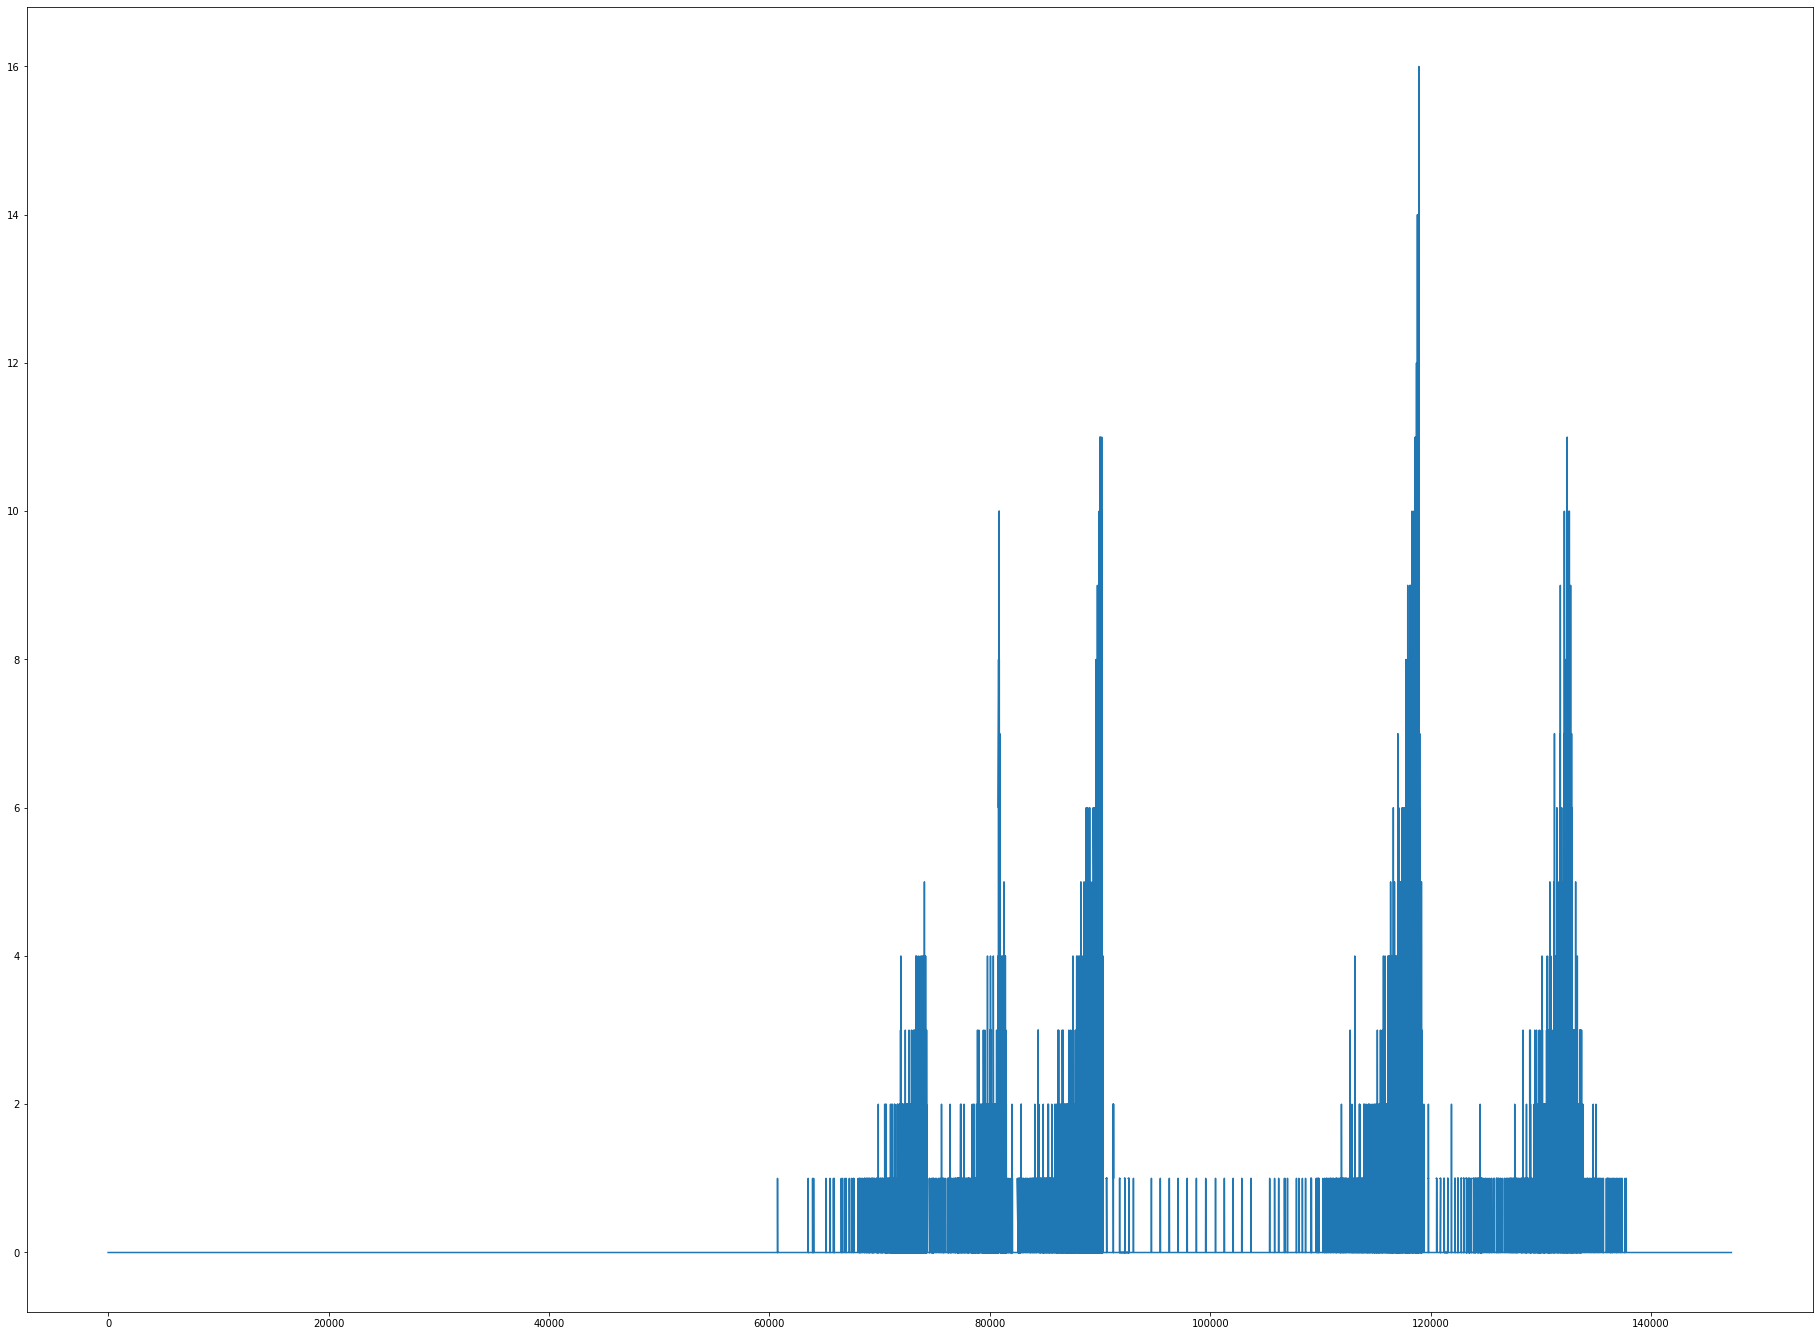

In [17]:
plt.figure(figsize=(32, 24))
plt.plot(new_sequence_numbers, num_retries)
plt.show()

Plot the number of retries per unique sequence number to notice any interesting trends

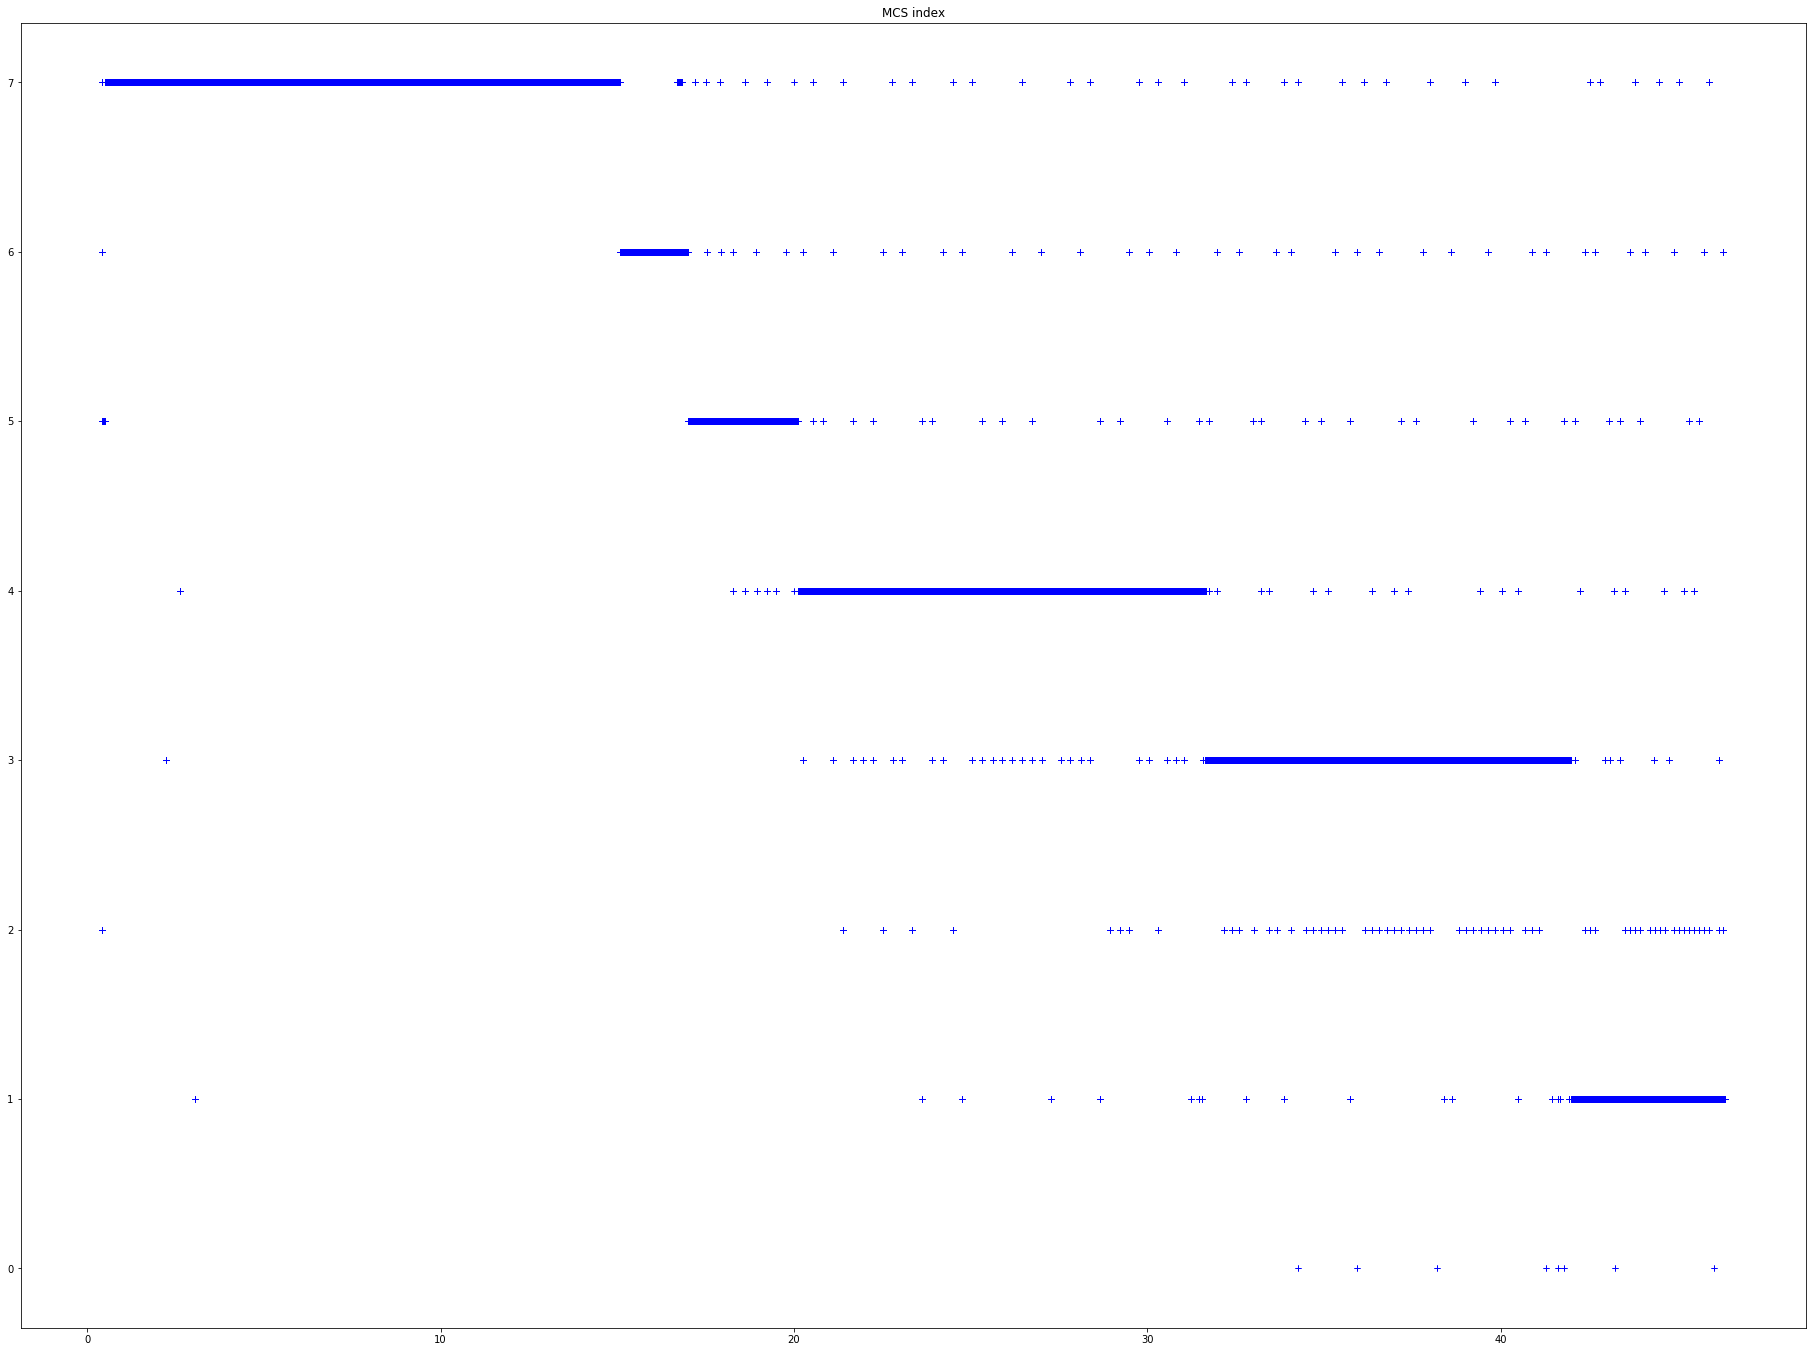

In [18]:
plt.figure(figsize=(32, 24))
plt.title("MCS index")
plt.plot(time, mcs_values, 'b+')
plt.show()

Plot the MCS index of each data packet to notice any interesting trends

# Plot the throughput vs time

In [19]:
start_time = time.iloc[0]
print(start_time)

0.407359


In [20]:
throughput_values = []

curr_time = start_time
i = 0

while i < len(udp_packets):
    total_bytes = 0
    while i < len(udp_packets) and time.iloc[i] < curr_time + 1.0:
        total_bytes += data.iloc[i]
        i += 1
    throughput_values.append(total_bytes)
    curr_time = time.iloc[i-1]

We consider a 1 second window to calculate the number of bytes received within the window

In [21]:
print(len(throughput_values))
throughput = np.asarray(throughput_values)

47


In [22]:
plt.figure(figsize=(32, 24))
plt.title("Throughput")
plt.plot(throughput)
plt.show()

Plot the throughput vs time graph to notice any interesting trends

# Plot the A-MPDU size over time

In [23]:
print(ampdu_ref.isna().sum())

16


Check if there are any packets with no A-MPDU reference number

In [24]:
offset = 0
for i in range(0, len(ampdu_ref)):
    if np.isnan(ampdu_ref.iloc[i]):
        offset += 1
        ampdu_ref.iat[i] = int(ampdu_ref.iloc[i-1]) + 1
    else:
        ampdu_ref.iat[i] = int(ampdu_ref.iloc[i]) + offset

Fill in the missing values for the A-MPDU reference number

In [25]:
print(ampdu_ref.isna().sum())

0


In [26]:
print(ampdu_ref.tail())

169476    8592.0
169477    8592.0
169478    8592.0
169479    8592.0
169480    8592.0
Name: A-MPDU reference number, dtype: float64


In [27]:
last_ampdu_ref = int(udp_packets.iloc[len(udp_packets) - 1]["A-MPDU reference number"])
print(last_ampdu_ref)
time_index = np.zeros(last_ampdu_ref+1)
ampdu_sizes = np.zeros(last_ampdu_ref+1)

for i in range(0, len(udp_packets)):
    current_ampdu_ref = int(ampdu_ref.iloc[i])
    if time_index[current_ampdu_ref] == 0:
        time_index[current_ampdu_ref] = time.iloc[i]
    if current_ampdu_ref >= 0:
        ampdu_sizes[current_ampdu_ref] += 1

8592


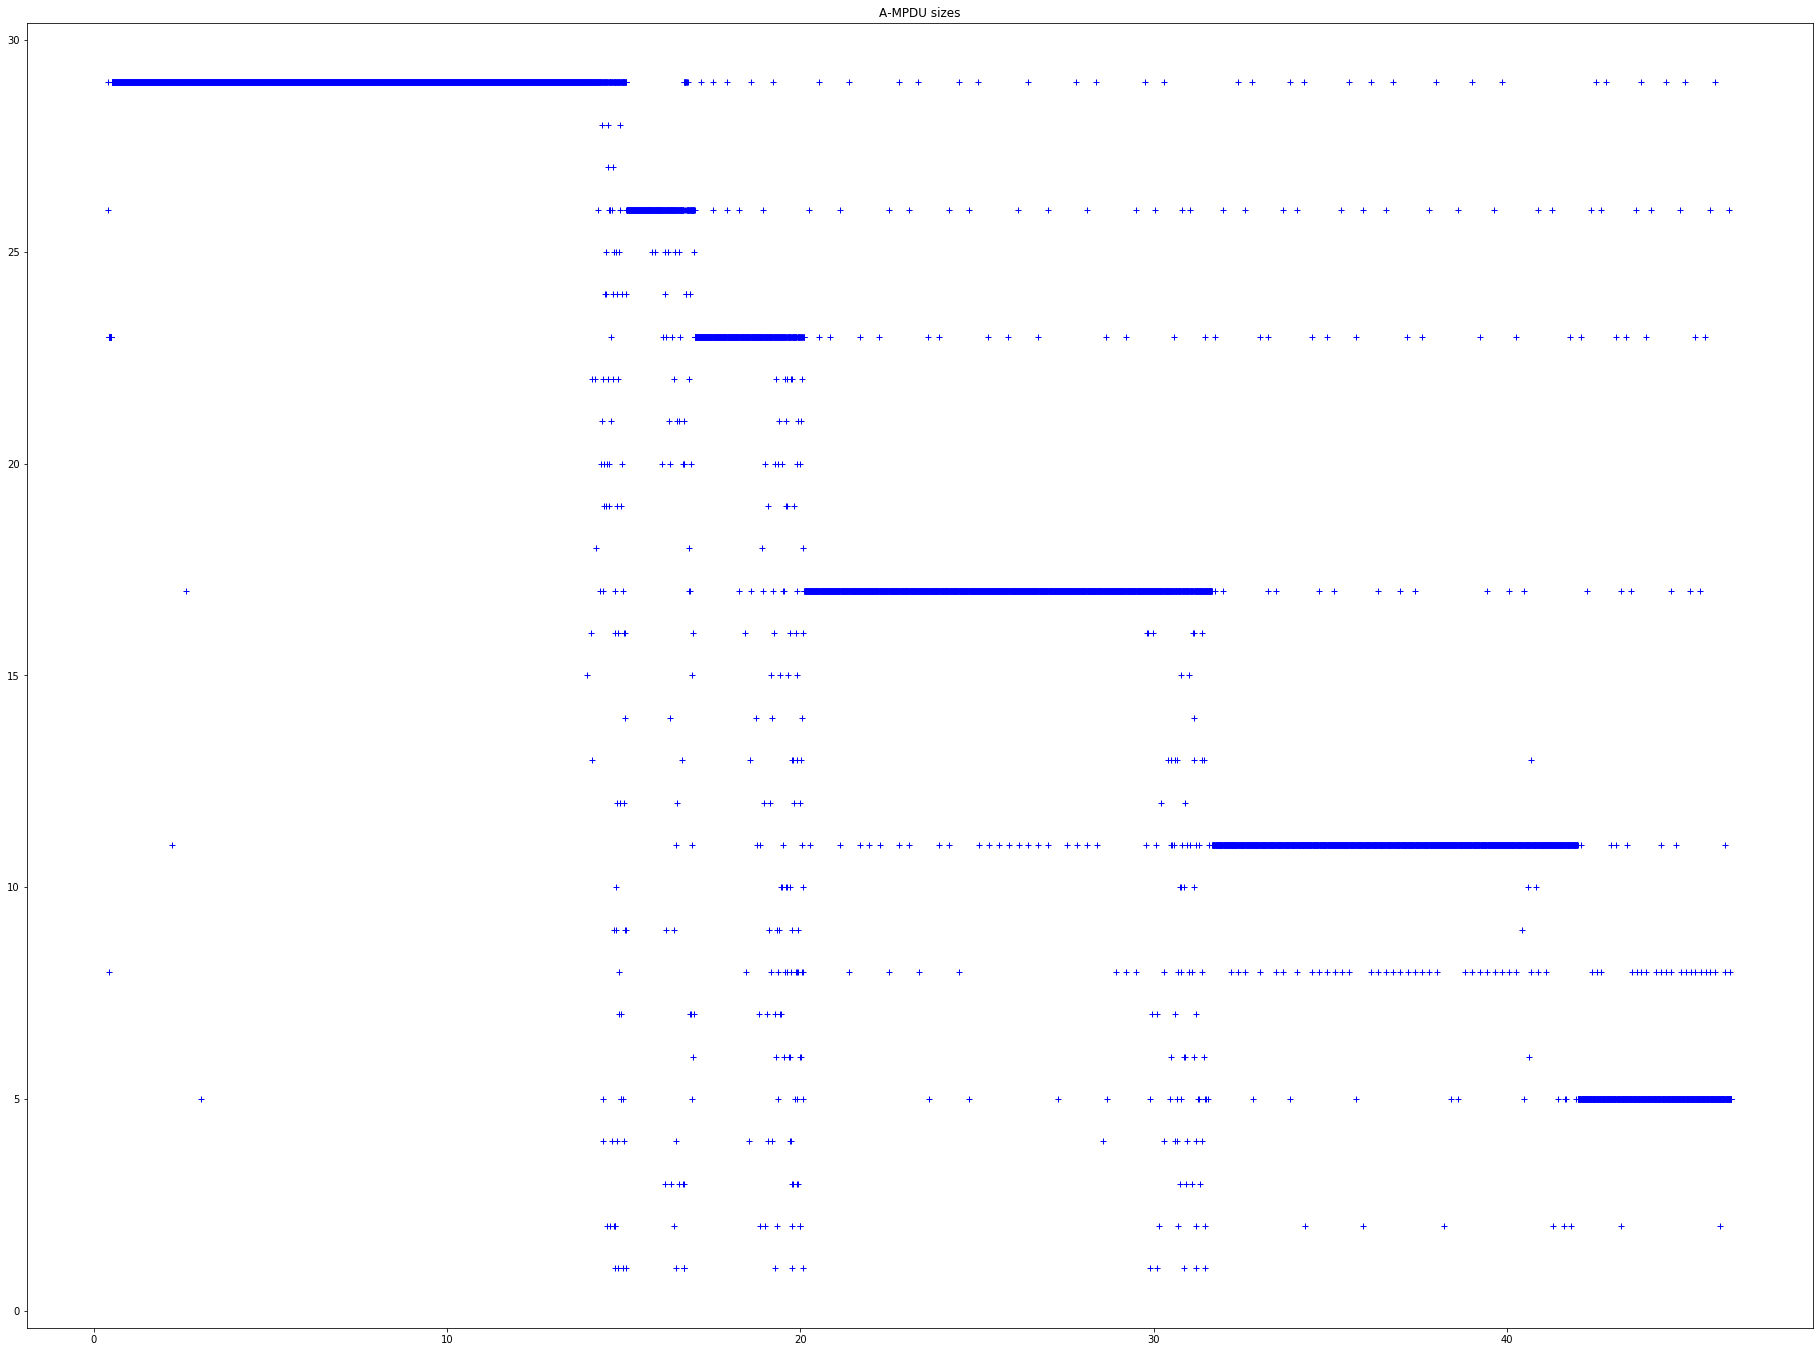

In [28]:
plt.figure(figsize=(32, 24))
plt.title("A-MPDU sizes")
plt.plot(time_index, ampdu_sizes, 'b+')
plt.show()

In [29]:
file = open('main-experiment-1/retry_information.txt', 'w')

for seq_number in range(0, len(new_sequence_numbers)):
    if num_retries[seq_number] > 0:
        #print("This sequence number retried more than once:", seq_number)
        file.write("This sequence number retries more than once: {}\n".format(seq_number))
        #print("Information about all retries:")
        file.write("Information about all retries:\n")
        all_data = udp_packets[udp_packets["New Sequence number"] == seq_number]
        my_time = all_data["Time"]
        my_mcs = all_data["MCS index"]
        my_ampdu_ref = all_data["A-MPDU reference number"]
        for i in range(0, len(all_data)):
            #print("Retry", i+1)
            file.write("Retry: {}\n".format(i+1))
            #print("Time:", my_time.iloc[i], end=' ')
            file.write("Time: {}".format(my_time.iloc[i]))
            #print("MCS:", my_mcs.iloc[i], end=' ')
            file.write("MCS: {}".format(my_mcs.iloc[i]))
            #print("AMPDU-size:", ampdu_sizes[int(my_ampdu_ref.iloc[i])])
            file.write("AMPDU-size: {}\n".format(ampdu_sizes[int(my_ampdu_ref.iloc[i])]))
            
file.close()